# Bayesian black-box model-predictive control

An Expected Free Energy minimizing agent based on a nonlinear autoregressive model with exogenous input.

## System: NARX

Consider a system generating observations $y_k \in \mathbb{R}$ based on inputs $u_k \in \mathbb{R}$:

$$ y_k = \theta^{\top}\phi(u_k, x_k) + e_k \, ,$$

where $x_k \in \mathbb{R}^{D}$ is a vector of previous observations and $\theta$ are coefficients. The noise instances $e_k$ are assumed to be zero-mean Gaussian distributed with variance $\sigma^2$.

In [1]:
using Revise
using ForwardDiff
using Optim
using RxInfer
using SpecialFunctions
using LinearAlgebra
using ProgressMeter
using Distributions
using Plots; default(grid=false, label="", linewidth=3, margin=20Plots.pt)

includet("../NARXAgents.jl"); using .NARXAgents
includet("./NARXsystem.jl"); using .NARXsystem

In [2]:
# Define system parameters
sys_mnoise_sd = 0.01;
input_lims = (-5.,5.)

H = 3
sys_basis(x) = cat([1; [x.^d for d in 1:H]]...,dims=1)
# rbf(x, a=0.0, l=1.0) = exp(-(x-a)^2./l)
# sys_basis(x) = cat([1; [rbf(x, a=a) for a in range(-1, stop=1, length=H)]]...,dims=1)

M_in = 2
M_out = 2
M = size(sys_basis(zeros(1 + M_in + M_out)),1);
# sys_coefficients = [0.0, 0.2, -1., -.8, -.01, -.01, -.01]
sys_coefficients = [0.0; randn(M-1).*range(M-1, step=-1, stop=1)./100]

16-element Vector{Float64}:
  0.0
 -0.026246038895444867
  0.12582145860969363
  0.10096867544175742
  0.016205842859296868
 -0.09389622057343822
  0.08970343850543452
 -0.06614928483253428
  0.08171867623468305
 -0.01409177846901246
  0.03061135390455094
 -0.07503544584760062
 -0.034834903077997185
  0.00889917997375237
  0.012164830821015143
 -0.013992960639790745

In [3]:
# Time
N = 100
Δt = 0.1
tsteps = collect(range(0.0, step=Δt, length=N));

In [4]:
# Inputs
A  = rand(10)*200 .- 100
Ω  = rand(10)*3
controls = mean([A[i]*sin.(Ω[i].*tsteps) for i = 1:10]) ./ 10;
# controls = [0.0; 3*ones(N-1)]

100-element Vector{Float64}:
  0.0
  0.0850826886825055
  0.15692721826011913
  0.2034133389301656
  0.21456003212973088
  0.18336204268312073
  0.10636946489425043
 -0.016039451643124494
 -0.1797154409196844
 -0.3771197561928253
  ⋮
 -1.076869598320163
 -1.1267581007985352
 -1.188814000091003
 -1.259432824930263
 -1.333504545294545
 -1.4048865428611488
 -1.466990692992681
 -1.5134244757090127
 -1.5386202885385258

In [5]:
# Outputs

system = NARXsys(sys_coefficients, sys_basis, sys_mnoise_sd, order_outputs=M_out, order_inputs=M_in, input_lims=input_lims)

outputs = zeros(N)
inputs = zeros(N)
for k in 1:N
    NARXsystem.update!(system, controls[k])
    outputs[k] = system.observation
    inputs[k] = system.input_buffer[1]
end

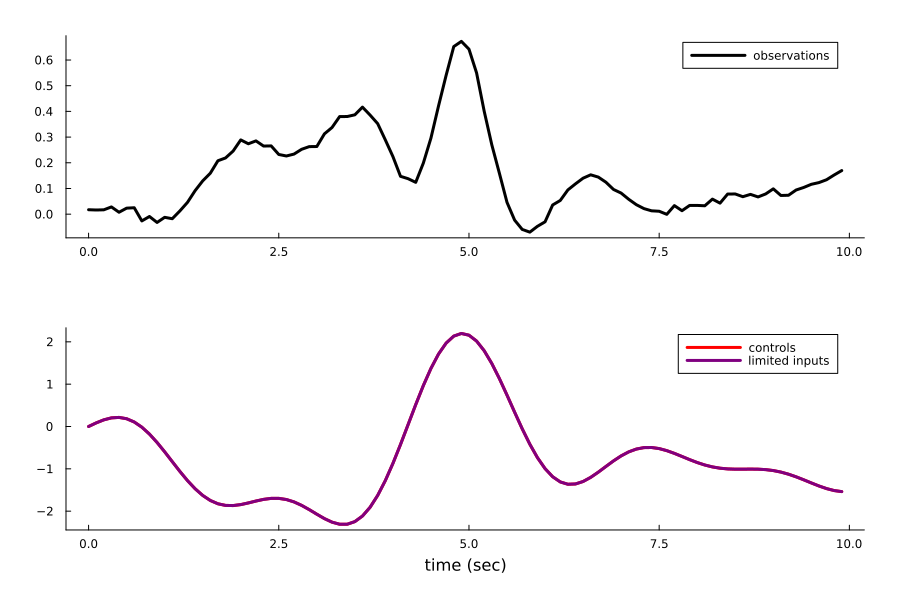

In [6]:
p101 = plot(tsteps, outputs, color="black", label="observations")
p102 = plot(tsteps, controls, color="red", label="controls", xlabel="time (sec)")
plot!(tsteps, inputs, color="purple", label="limited inputs", xlabel="time (sec)")
plot(p101, p102, layout=grid(2,1), size=(900,600))

## NARX parameter estimation

In [7]:
# Polynomial degree
H = 3

# Delay order
Ly = M_in
Lu = M_out

# Model order
M = size(ϕ(zeros(1+Ly+Lu), degree=H),1);

In [8]:
# Specify prior distributions
pτ0 = GammaShapeRate(1e1, 1e0)
pθ0 = MvNormalMeanCovariance(ones(M), 1e3diagm(ones(M)))

MvNormalMeanCovariance(
μ: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Σ: [1000.0 0.0 … 0.0 0.0; 0.0 1000.0 … 0.0 0.0; … ; 0.0 0.0 … 1000.0 0.0; 0.0 0.0 … 0.0 1000.0]
)


In [9]:
agent = NARXAgent(pθ0, pτ0, delay_in=Lu, delay_out=Ly, pol_degree=H)

NARXAgent(FactorGraphModel(), Constraints:
  marginals form:
  messages form:
  factorisation:
    q(θ, τ) = q(θ)q(τ)
Options:
  warn = true
, [Inf], MvNormalMeanCovariance(
μ: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Σ: [1000.0 0.0 … 0.0 0.0; 0.0 1000.0 … 0.0 0.0; … ; 0.0 0.0 … 1000.0 0.0; 0.0 0.0 … 0.0 1000.0]
)
, GammaShapeRate{Float64}(a=10.0, b=1.0), NormalMeanVariance{Float64}(μ=0.0, v=1.0), 1, 10, 1.0, 2, 2, 3, 16, [0.0, 0.0], [0.0, 0.0, 0.0])

In [10]:
py = []
qθ = [pθ0]
qτ = [pτ0]
FE = zeros(10,N)

T = 1
@showprogress for k in 1:(N-T)
    
    # Make predictions
    push!(py, predictions(agent, controls[k:k+T], time_horizon=T))
    
    # Update beliefs
    NARXAgents.update!(agent, outputs[k], controls[k])
    push!(qθ, agent.qθ)
    push!(qτ, agent.qτ)
    
    # Evaluate
    FE[:,k] = agent.free_energy
end

Progress:   2%|▉                                        |  ETA: 0:08:49

Progress: 100%|█████████████████████████████████████████| Time: 0:00:11


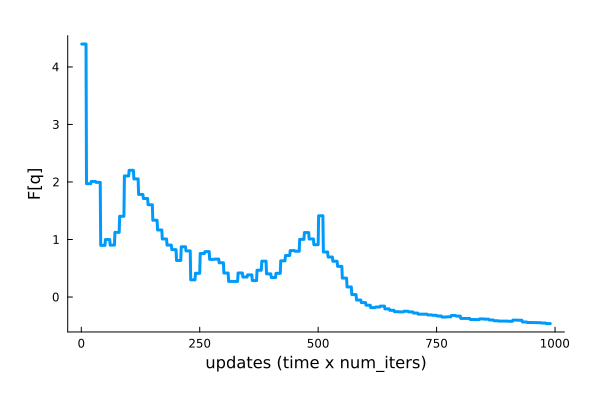

In [11]:
plot(reshape(FE[:,1:(N-T)], (10*(N-T),)), xlabel="updates (time x num_iters)", ylabel="F[q]")

In [12]:
vθ = cat( var.(qθ)...,dims=2)
mθ = cat(mean.(qθ)...,dims=2)

16×100 Matrix{Float64}:
 1.0  0.0173722   0.015939   0.0169936  …   0.00500429    0.00504523
 1.0  1.0         0.752403   0.948668      -0.179024     -0.178876
 1.0  1.0         1.0        0.768185      -0.0259432    -0.0279578
 1.0  1.0        -0.219541  -0.286322      -0.000156919  -0.000961296
 1.0  1.0         1.0       -0.141807       0.289351      0.291165
 1.0  1.0         1.0        1.0        …  -0.252098     -0.253128
 1.0  1.0         0.995723   0.999342      -0.210551     -0.205412
 1.0  1.0         1.0        0.995996      -0.0247893    -0.0212307
 1.0  1.0         0.896238   0.739255       0.0878243     0.0879406
 1.0  1.0         1.0        0.902852      -0.0259041    -0.0263388
 1.0  1.0         1.0        1.0        …   0.0709095     0.0711813
 1.0  1.0         0.999926   0.999992       0.273397      0.269605
 1.0  1.0         1.0        0.999931      -0.066642     -0.0707247
 1.0  1.0         0.991172   0.954072      -0.00421553   -0.00419434
 1.0  1.0         1.0    

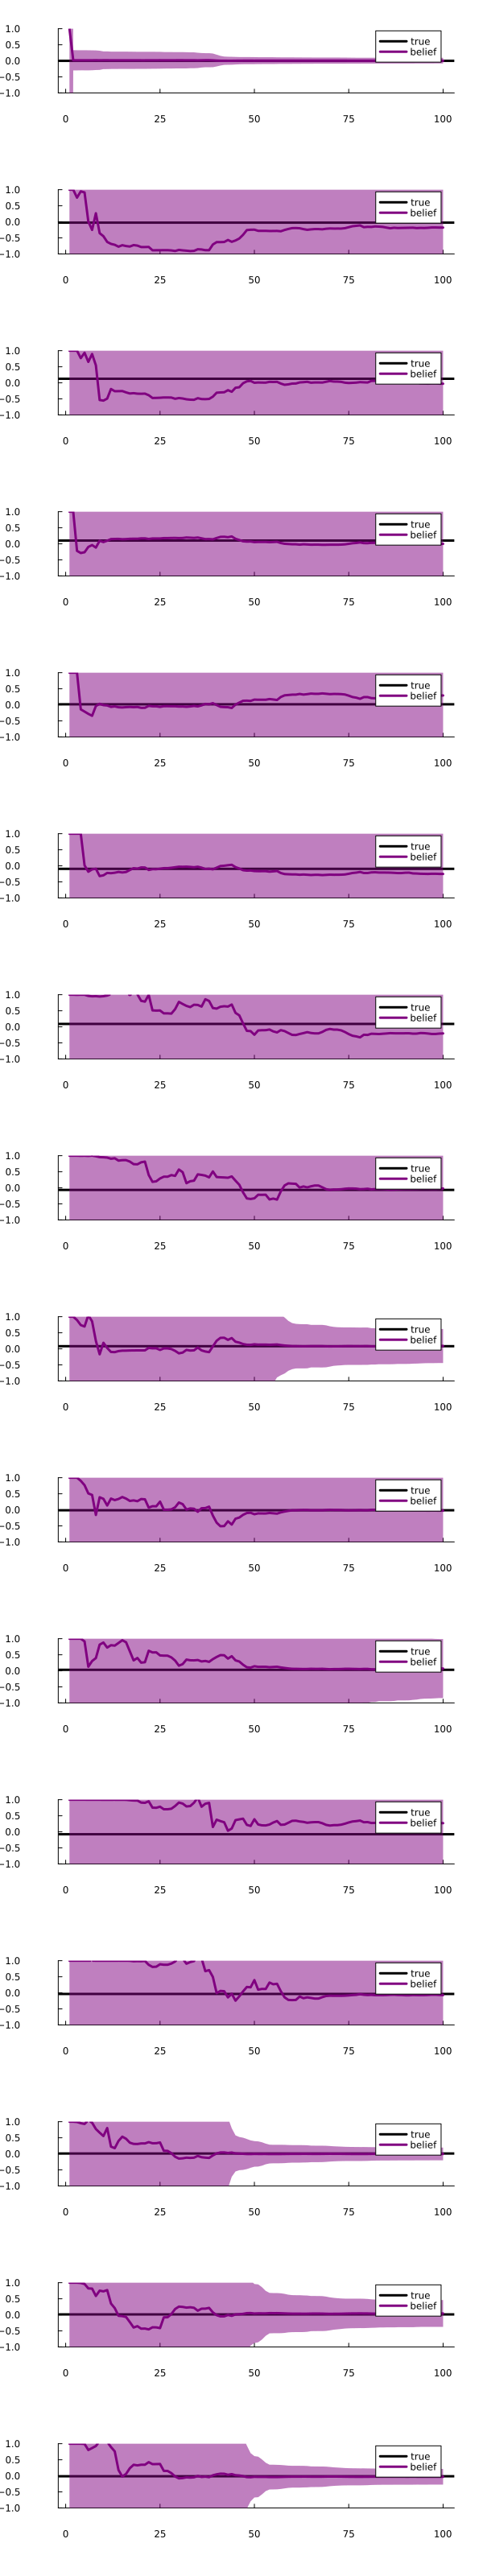

In [13]:
pw = []
for m in 1:M
    pwm = plot(ylims=(-1.,1.))
    
    hline!([sys_coefficients[m]], color="black", label="true")
    plot!(mθ[m,:], ribbon=sqrt.(vθ[m,:]), color="purple", label="belief", ylabel="θ_$m")
    
    push!(pw,pwm)
end
plot(pw..., layout=(M,1), size=(600,M*200))

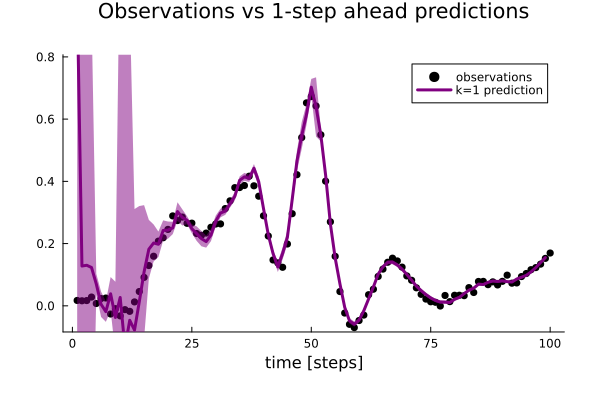

In [15]:
limsb = [minimum(outputs)*1.2, maximum(outputs)*1.2]
K = 1

p1 = plot(xlabel="time [steps]", title="Observations vs $K-step ahead predictions", ylims=limsb)
scatter!(outputs, color="black", label="observations")
plot!([mean(py[k][K]) for k in 1:(N-T)], ribbon=[var(py[k][K]) for k in 1:(N-T)], color="purple", label="k=$K prediction")

## Experiments

In [16]:
# Length of trial
N = 200
tsteps = range(0.0, step=Δt, length=N)
T = 3

# Orders
H = 3
Ly = M_in
Lu = M_out
M = size(ϕ(zeros(1+Ly+Lu), degree=H),1);

# Set control properties
goal = NormalMeanVariance(1.0, 1e-4)
control_prior = 0.0
num_iters = 10
u_lims = (-5., 5.)
tlimit = 300

# Specify prior distributions
pτ0 = GammaShapeRate(1e2, 1e0)
pθ0 = MvNormalMeanCovariance(randn(M)./1e2, 1e1diagm(ones(M)))

MvNormalMeanCovariance(
μ: [-0.00013695833903460604, -0.008447917759004607, 0.0013877315711767768, -0.02053811119835891, -0.0030252799999975198, 0.005010414470087365, 0.007889156383816672, -0.0037384897743759555, -0.013198806315494478, 0.007817834151180515, -0.005286027931262257, -0.00850407004137145, 0.005865723754815056, -0.0020074709424214836, -0.006758879229437573, 0.0020272895419011336]
Σ: [10.0 0.0 … 0.0 0.0; 0.0 10.0 … 0.0 0.0; … ; 0.0 0.0 … 10.0 0.0; 0.0 0.0 … 0.0 10.0]
)


### Expected Free Energy minimization

In [17]:
# Start system
system = NARXsys(sys_coefficients, 
                 sys_basis,
                 sys_mnoise_sd, 
                 order_outputs=M_out, 
                 order_inputs=M_in)

# Start agent
agent = NARXAgent(pθ0, pτ0, 
                  goal_prior=goal, 
                  delay_in=Lu, 
                  delay_out=Ly, 
                  pol_degree=H,
                  thorizon=T,
                  control_prior=0.0,
                  num_iters=num_iters)

# Preallocate
y_EFE = zeros(N)
u_EFE = zeros(N+1)
pτ_EFE = [pτ0]
pθ_EFE = [pθ0]
py_EFE = []
FE_EFE = zeros(num_iters, N)

@showprogress for k in 1:N
    
    # Act upon environment
    NARXsystem.update!(system, u_EFE[k])
    y_EFE[k] = system.observation
    
    # Update parameter beliefs
    NARXAgents.update!(agent, y_EFE[k], u_EFE[k])
    
    FE_EFE[:,k] = agent.free_energy
    push!(pθ_EFE, agent.qθ)
    push!(pτ_EFE, agent.qτ)
    
    # Optimal control
    policy = minimizeEFE(agent, time_limit=tlimit, control_lims=u_lims)
    u_EFE[k+1] = policy[1]
    
    # Store future predictions
    push!(py_EFE, predictions(agent, policy, time_horizon=T))
    
end

Progress:   1%|▍                                        |  ETA: 0:08:04

Progress:  10%|████▎                                    |  ETA: 0:00:43

Progress:  20%|████████▍                                |  ETA: 0:00:20

Progress:  31%|████████████▊                            |  ETA: 0:00:12

Progress:  42%|█████████████████▎                       |  ETA: 0:00:07

Progress:  52%|█████████████████████▍                   |  ETA: 0:00:05

Progress:  62%|█████████████████████████▍               |  ETA: 0:00:03

Progress:  72%|█████████████████████████████▊           |  ETA: 0:00:02

Progress:  82%|█████████████████████████████████▉       |  ETA: 0:00:01

Progress:  94%|██████████████████████████████████████▌  |  ETA: 0:00:00

Progress: 100%|█████████████████████████████████████████| Time: 0:00:05


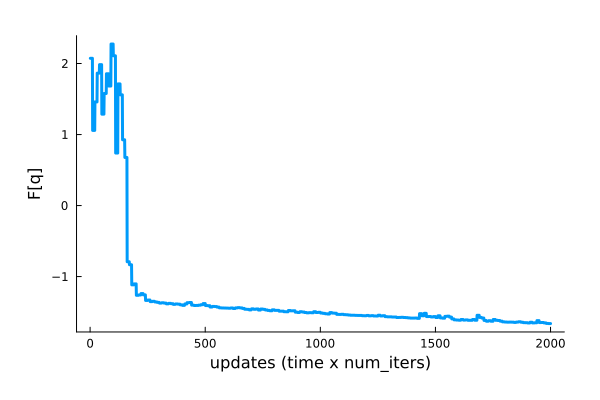

In [18]:
plot(FE_EFE[:], xlabel="updates (time x num_iters)", ylabel="F[q]")

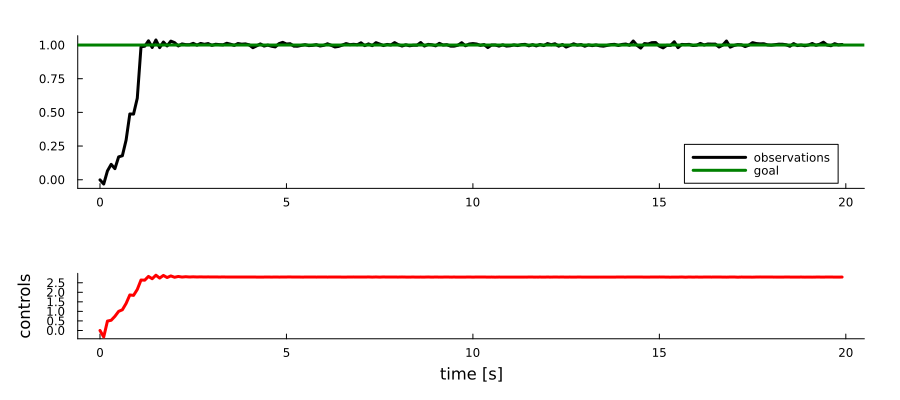

In [19]:
p1 = plot(tsteps, y_EFE, color="black", label="observations")
hline!([mean(goal)], color="green", label="goal")
p4 = plot(tsteps, u_EFE[1:end-1], color="red", ylabel="controls", xlabel="time [s]")

plot(p1,p4, layout=grid(2,1, heights=[.7, .3]), size=(900,400))

In [20]:
savefig("figures/NARX-EFE-verification-trial.png")

"/home/wmkouw/syndr/Wouter/Onderzoek/Projecten/tue/efe-acquisition/narx-efe/verification/figures/NARX-EFE-verification-trial.png"

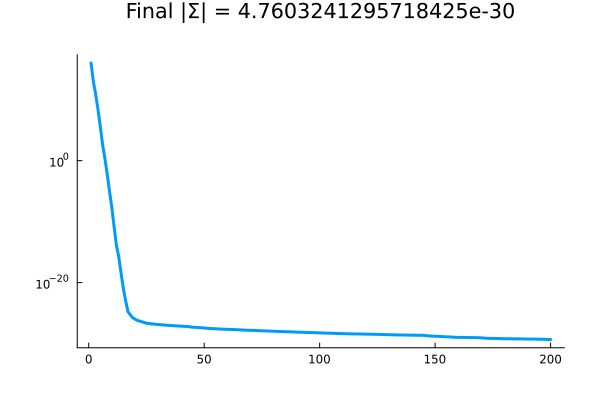

In [21]:
dSθ_EFE = [det(cov(pθ_EFE[k])) for k in 1:N]
final_dSθ_EFE = dSθ_EFE[end]
plot(dSθ_EFE, title="Final |Σ| = $final_dSθ_EFE", yscale=:log10)

In [22]:
[tr(cov(pθ_EFE[k])) for k in 1:N]

200-element Vector{Float64}:
 160.0
 150.00998995864023
 140.16209203932078
 130.38440775463667
 120.4694300605221
 110.49375291654114
 100.90840490780546
  91.01956831183159
  81.23259667957846
  73.42860036362369
   ⋮
  19.849588862882875
  19.844071856022587
  19.841906142223475
  19.83830327388126
  19.837466267272355
  19.82073594796646
  19.803737984282595
  19.800477340373266
  19.797922652063324

┌ Info: Saved animation to /home/wmkouw/syndr/Wouter/Onderzoek/Projecten/tue/efe-acquisition/narx-efe/verification/figures/NARX-EFE-verification-planning.gif
└ @ Plots /home/wmkouw/.julia/packages/Plots/3BCH5/src/animation.jl:156


Plots.AnimatedGif("/home/wmkouw/syndr/Wouter/Onderzoek/Projecten/tue/efe-acquisition/narx-efe/verification/figures/NARX-EFE-verification-planning.gif")
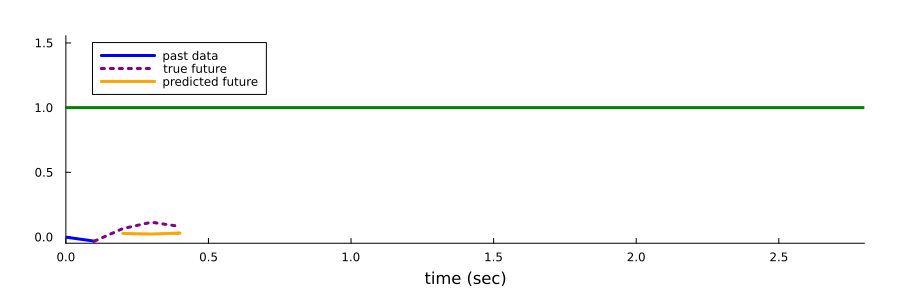

In [23]:
limsb = [minimum(y_EFE)*1.5, maximum(y_EFE)*1.5]

window = 20

anim = @animate for k in 2:(N-T-1)
    
    if k <= window
        plot(tsteps[1:k], y_EFE[1:k], color="blue", xlims=(tsteps[1], tsteps[window+T+1]+0.5), label="past data", xlabel="time (sec)", ylims=limsb, size=(900,300))
        plot!(tsteps[k:k+T], y_EFE[k:k+T], color="purple", label="true future", linestyle=:dot)
        plot!(tsteps[k+1:k+T], mean.(py_EFE[k]), ribbon=var.(py_EFE[k]), label="predicted future", color="orange", legend=:topleft)
        hline!([mean(goal)], color="green")
    else
        plot(tsteps[k-window:k], y_EFE[k-window:k], color="blue", xlims=(tsteps[k-window], tsteps[k+T+1]+0.5), label="past data", xlabel="time (sec)", ylims=limsb, size=(900,300))
        plot!(tsteps[k:k+T], y_EFE[k:k+T], color="purple", label="true future", linestyle=:dot)
        plot!(tsteps[k+1:k+T], mean.(py_EFE[k]), ribbon=var.(py_EFE[k]), label="prediction", color="orange", legend=:topleft)
        hline!([mean(goal)], color="green")
    end
    
end
gif(anim, "figures/NARX-EFE-verification-planning.gif", fps=24)

### Mean Squared Error minimization

In [34]:
# Start system
system = NARXsys(sys_coefficients, 
                 sys_basis,
                 sys_mnoise_sd, 
                 order_outputs=M_out, 
                 order_inputs=M_in,
                 input_lims=input_lims)

# Start agent
agent = NARXAgent(pθ0, pτ0, 
                  goal_prior=goal, 
                  delay_in=Lu, 
                  delay_out=Ly, 
                  pol_degree=H,
                  thorizon=T,
                  control_prior=control_prior,
                  num_iters=num_iters)

# Preallocate
y_MSE = zeros(N)
u_MSE = zeros(N+1)
pτ_MSE = [pτ0]
pθ_MSE = [pθ0]
py_MSE = []
FE_MSE = zeros(num_iters, N)

@showprogress for k in 1:N
    
    # Act upon environment
    NARXsystem.update!(system, u_MSE[k])
    y_MSE[k] = system.observation
    
    # Update parameter beliefs
    NARXAgents.update!(agent, y_MSE[k], u_MSE[k])
    
    FE_MSE[:,k] = agent.free_energy
    push!(pθ_MSE, agent.qθ)
    push!(pτ_MSE, agent.qτ)
    
    # Optimal control
    policy = minimizeMSE(agent, time_limit=tlimit, control_lims=u_lims)
    u_MSE[k+1] = policy[1]
    
    # Store future predictions
    push!(py_MSE, predictions(agent, policy, time_horizon=T))
    
end

Progress:   2%|▋                                        |  ETA: 0:00:07

Progress:  14%|██████                                   |  ETA: 0:00:01

Progress:  32%|█████████████▍                           |  ETA: 0:00:01

Progress:  49%|████████████████████▏                    |  ETA: 0:00:00

Progress:  66%|███████████████████████████              |  ETA: 0:00:00

Progress:  82%|█████████████████████████████████▋       |  ETA: 0:00:00

Progress:  98%|████████████████████████████████████████▍|  ETA: 0:00:00

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


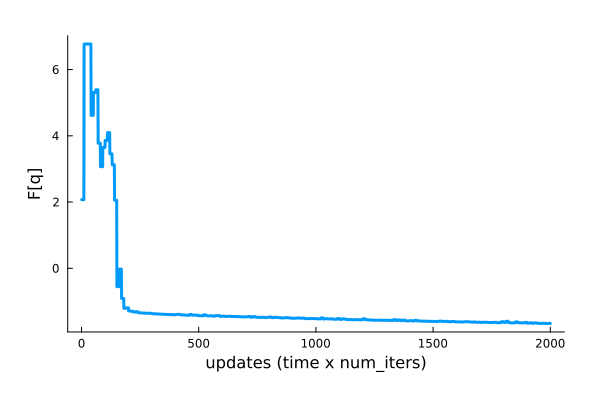

In [35]:
plot(FE_MSE[:], xlabel="updates (time x num_iters)", ylabel="F[q]")

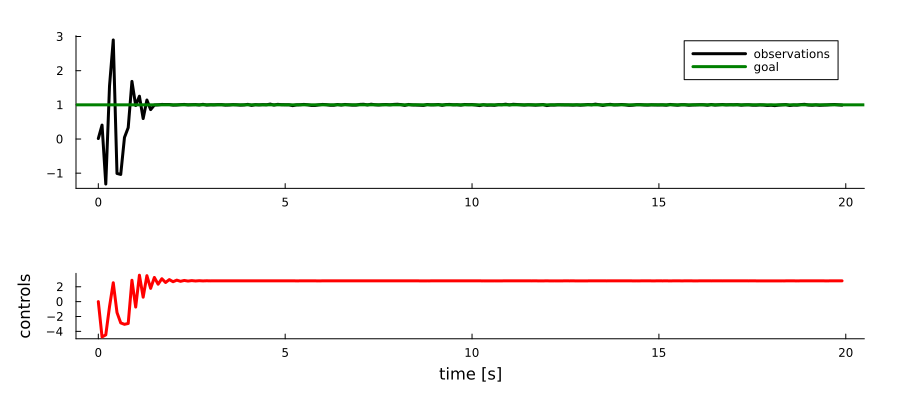

In [36]:
p1 = plot(tsteps, y_MSE, color="black", label="observations")
hline!([mean(goal)], color="green", label="goal")
p4 = plot(tsteps, u_MSE[1:end-1], color="red", ylabel="controls", xlabel="time [s]")

plot(p1,p4, layout=grid(2,1, heights=[.7, .3]), size=(900,400))

In [37]:
savefig("figures/NARX-MSE-verification-trial.png")

"/home/wmkouw/syndr/Wouter/Onderzoek/Projecten/tue/efe-acquisition/narx-efe/verification/figures/NARX-MSE-verification-trial.png"

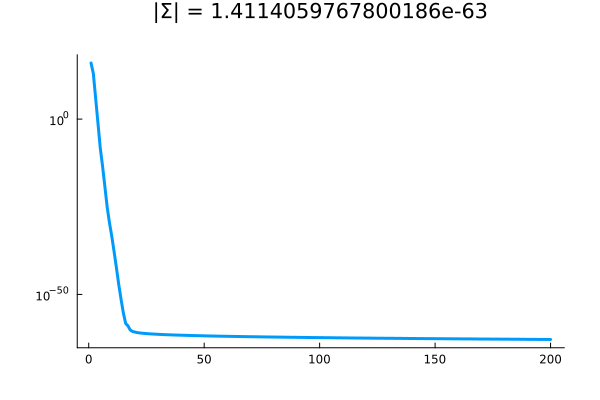

In [38]:
dSθ_MSE = [det(cov(pθ_MSE[k])) for k in 1:N]
final_dSθ_MSE = dSθ_MSE[end]
plot(dSθ_MSE, title="|Σ| = $final_dSθ_MSE", yscale=:log10)

┌ Info: Saved animation to /home/wmkouw/syndr/Wouter/Onderzoek/Projecten/tue/efe-acquisition/narx-efe/verification/figures/NARX-MSE-verification-planning.gif
└ @ Plots /home/wmkouw/.julia/packages/Plots/3BCH5/src/animation.jl:156


Plots.AnimatedGif("/home/wmkouw/syndr/Wouter/Onderzoek/Projecten/tue/efe-acquisition/narx-efe/verification/figures/NARX-MSE-verification-planning.gif")
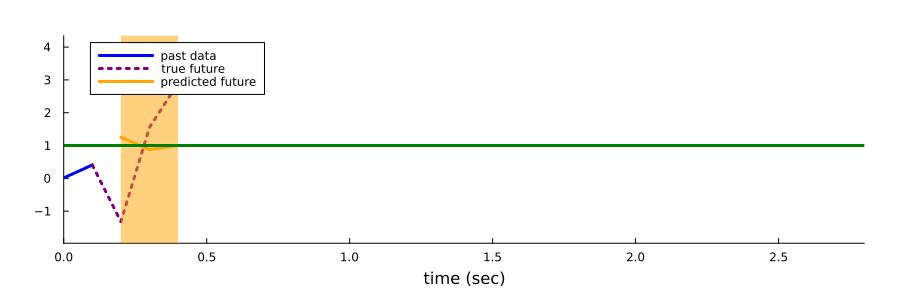

In [39]:
limsb = [minimum(y_MSE)*1.5, maximum(y_MSE)*1.5]
window = 20

anim = @animate for k in 2:(N-T-1)
    
    if k <= window
        plot(tsteps[1:k], y_MSE[1:k], color="blue", xlims=(tsteps[1], tsteps[window+T+1]+0.5), label="past data", xlabel="time (sec)", ylims=limsb, size=(900,300))
        plot!(tsteps[k:k+T], y_MSE[k:k+T], color="purple", label="true future", linestyle=:dot)
        plot!(tsteps[k+1:k+T], mean.(py_MSE[k]), ribbon=var.(py_MSE[k]), label="predicted future", color="orange", legend=:topleft)
        hline!([mean(goal)], color="green")
    else
        plot(tsteps[k-window:k], y_MSE[k-window:k], color="blue", xlims=(tsteps[k-window], tsteps[k+T+1]+0.5), label="past data", xlabel="time (sec)", ylims=limsb, size=(900,300))
        plot!(tsteps[k:k+T], y_MSE[k:k+T], color="purple", label="true future", linestyle=:dot)
        plot!(tsteps[k+1:k+T], mean.(py_MSE[k]), ribbon=var.(py_MSE[k]), label="prediction", color="orange", legend=:topleft)
        hline!([mean(goal)], color="green")
    end
    
end
gif(anim, "figures/NARX-MSE-verification-planning.gif", fps=24)

### Comparison

In [40]:
println("Final |Σ| MSE = $final_dSθ_MSE")
println("Final |Σ| EFE = $final_dSθ_EFE")

Final |Σ| MSE = 1.4114059767800186e-63
Final |Σ| EFE = 4.7603241295718425e-30


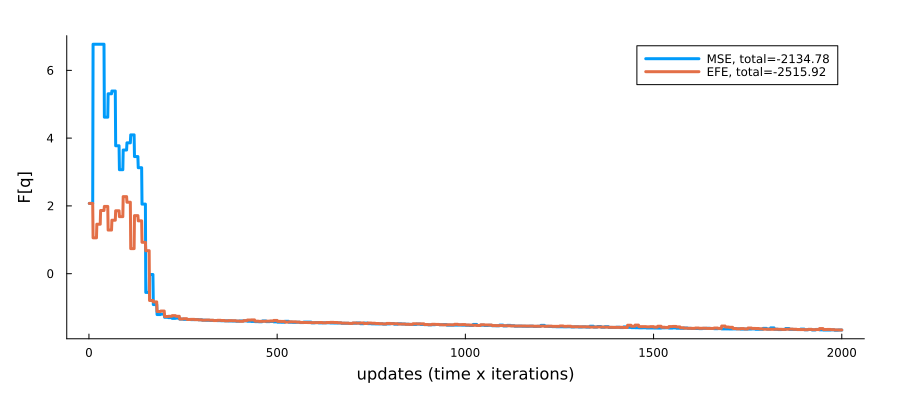

In [41]:
sF_MSE = round(sum(FE_MSE[:]), digits=2)
sF_EFE = round(sum(FE_EFE[:]), digits=2)

plot(xlabel="updates (time x iterations)", ylabel="F[q]", size=(900,400))
plot!(FE_MSE[:], label="MSE, total=$sF_MSE")
plot!(FE_EFE[:], label="EFE, total=$sF_EFE")

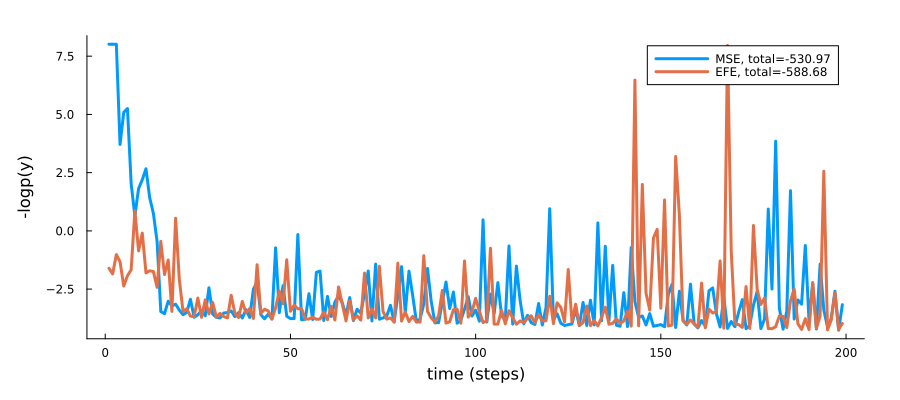

In [42]:
evidence_MSE = [-logpdf(py_MSE[k][1], y_MSE[k+1]) for k in 1:(N-1)]
evidence_EFE = [-logpdf(py_EFE[k][1], y_EFE[k+1]) for k in 1:(N-1)]

total_evidence_MSE = round(sum(evidence_MSE), digits=2)
total_evidence_EFE = round(sum(evidence_EFE), digits=2)

plot(xlabel="time (steps)", ylabel="-logp(y)", size=(900,400))
plot!(evidence_MSE, label="MSE, total=$total_evidence_MSE")
plot!(evidence_EFE, label="EFE, total=$total_evidence_EFE")

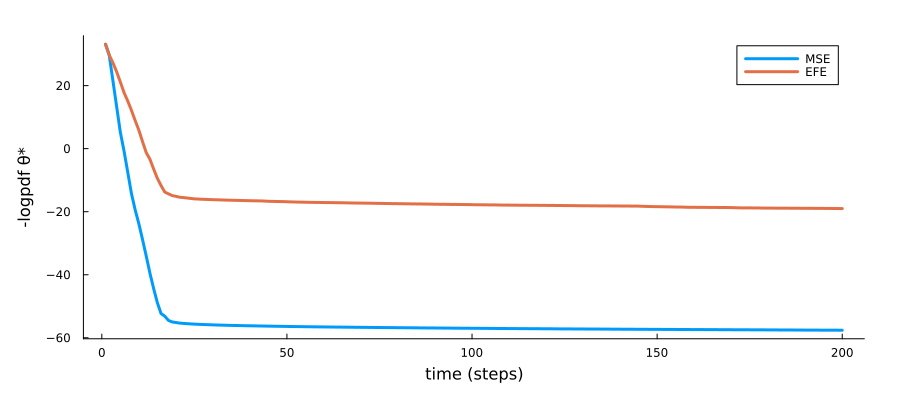

In [43]:
idθ_MSE = [-logpdf(pθ_MSE[k], sys_coefficients) for k in 1:N]
idθ_EFE = [-logpdf(pθ_EFE[k], sys_coefficients) for k in 1:N]

plot(xlabel="time (steps)", ylabel="-logpdf θ*", size=(900,400))
plot!(idθ_MSE, label="MSE")
plot!(idθ_EFE, label="EFE")

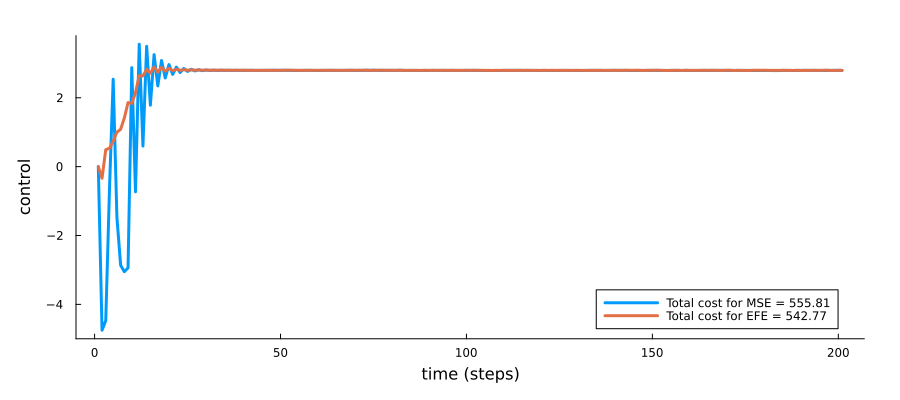

In [46]:
CC_MSE = round(sum(abs.(u_MSE)), digits=2)
CC_EFE = round(sum(abs.(u_EFE)), digits=2)

plot(xlabel="time (steps)", ylabel="control", size=(900,400))
plot!(u_MSE, label="Total cost for MSE = $CC_MSE")
plot!(u_EFE, label="Total cost for EFE = $CC_EFE")

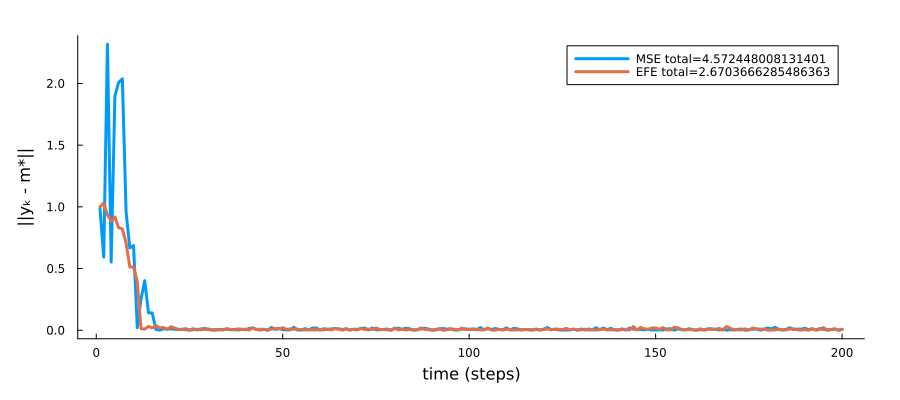

In [45]:
J_MSE = [norm(y_MSE[k] - mean(goal),2) for k in 1:N]
J_EFE = [norm(y_EFE[k] - mean(goal),2) for k in 1:N]

sJ_MSE = norm(y_MSE .- mean(goal),2)
sJ_EFE = norm(y_EFE .- mean(goal),2)

plot(xlabel="time (steps)", ylabel="||yₖ - m*||", size=(900,400))
plot!(J_MSE, label="MSE total=$sJ_MSE")
plot!(J_EFE, label="EFE total=$sJ_EFE")